# Cloud Chamber Single Cycle (split from Cloud_Chamber_Cycles.ipynb)

This notebook covers **sections 1–8** of the original combined tutorial.
It focuses on one activation–deactivation cycle that fits within CI time constraints.
For multi-cycle comparisons, see the companion [Cloud_Chamber_Multi_Cycle.ipynb](Cloud_Chamber_Multi_Cycle.ipynb).

**Learning objectives:**
- Configure chamber geometry and wall-loss settings.
- Define hygroscopic seeds with kappa-theory.
- Build a particle-resolved aerosol with speciated mass.
- Run a single activation and deactivation cycle.
- Visualize droplet growth/shrinkage and verify mass conservation.


# Cloud Chamber Activation-Deactivation Cycle (Single Run)

Welcome! This beginner-friendly notebook shows how to simulate one cloud activation-deactivation cycle in a rectangular cloud chamber using **Particula**. You will:

- Configure chamber geometry and wall-loss settings.
- Define hygroscopic seed composition with kappa-theory.
- Build a particle-resolved aerosol with speciated mass.
- Run one supersaturated activation (100.4% RH) and one deactivation (65% RH).
- Visualize droplet growth beyond 5 um and shrinkage during drying.
- Check mass conservation (within ~1%) and discuss reproducibility.

> Learning goals: understand Kohler/kappa activation basics, see how wall loss and condensation interact, and reuse this scaffold for multi-cycle studies.

## Imports, style, and reproducibility

In [73]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import particula as par

# Optional: uncomment if many steps and you want a progress bar
# from tqdm import tqdm

# Plot style (Tailwind gray palette)
TAILWIND = par.util.colors.TAILWIND
base_color = TAILWIND["gray"]["600"]
plt.rcParams.update(
    {
        "text.color": base_color,
        "axes.labelcolor": base_color,
        "figure.figsize": (5, 4),
        "font.size": 14,
        "axes.edgecolor": base_color,
        "xtick.color": base_color,
        "ytick.color": base_color,
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "savefig.dpi": 150,
    }
)

np.random.seed(100)  # reproducibility for sampling and wall-loss RNG


## 1. Chamber geometry and wall-loss setup
We model a rectangular cloud chamber. Wall loss is stochastic inside the strategy, so small run-to-run variability is expected even with a fixed seed (reproducibility mainly controls sampling order).

In [74]:
# Geometry (meters)
chamber_dims = (2.0, 1, 1)
chamber_volume = np.prod(chamber_dims)
print("Chamber volume (m^3):", chamber_volume)

# Rectangular wall-loss strategy
wall_loss_strategy = (
    par.dynamics.RectangularWallLossBuilder()
    .set_chamber_dimensions(chamber_dims)
    .set_wall_eddy_diffusivity(0.001, "1/s")
    .set_distribution_type("particle_resolved")
    .build()
)
wall_loss = par.dynamics.WallLoss(wall_loss_strategy=wall_loss_strategy)


Chamber volume (m^3): 2.0


## 2. Seed species and kappa-activity parameters
We track three species in each particle: ammonium sulfate, sucrose, and water (water index = 2). kappa-theory approximates water activity from composition; higher kappa means more hygroscopic. Kohler theory couples curvature and solute effects; kappa-theory is a convenient approximation.

In [75]:
kappa = np.array([0.61, 0.10, 0.0])
density = np.array([1770.0, 1587.0, 997.0])  # kg/m^3
molar_mass = np.array([0.13214, 0.3423, 0.018015])  # kg/mol
activity_params = (
    par.particles.ActivityKappaParameterBuilder()
    .set_kappa(kappa)
    .set_density(density, "kg/m^3")
    .set_molar_mass(molar_mass, "kg/mol")
    .set_water_index(2)
    .build()
)

## 3. Particle-resolved distribution, atmosphere, and initial aerosol
We create a particle-resolved speciated-mass representation using a lognormal sample distribution. Particles are sampled from a lognormal distribution with realistic CCN seed sizes. Water starts at zero; species ordering matches the kappa inputs.

In [76]:
# Sample particle radii from a lognormal distribution
# This is more realistic than manually spaced diameters
n_particles = 1000  # keep modest for speed
dry_radius = par.particles.get_lognormal_sample_distribution(
    mode=np.array([100e-9]),  # 100 nm mode radius (typical CCN seed size)
    geometric_standard_deviation=np.array([1.5]),  # typical GSD for accumulation mode
    number_of_particles=np.array([1.0]),  # single mode
    number_of_samples=n_particles,
)

# Seed masses per particle (kg) from sampled radii
# Species: ammonium sulfate, sucrose, water (matches kappa array order)
volume_per_particle = 4 / 3 * np.pi * dry_radius**3
# 60% ammonium sulfate, 40% sucrose by volume in dry seed
ammonium_sulfate_mass = 0.6 * volume_per_particle * density[0]  # kg
sucrose_mass = 0.4 * volume_per_particle * density[1]  # kg
water_mass0 = np.zeros_like(dry_radius)  # start dry
seed_mass = np.stack([ammonium_sulfate_mass, sucrose_mass, water_mass0], axis=1)

# Temperature and pressure
temperature = 298.15  # K
total_pressure = 101325.0  # Pa

# Create partitioning gas species (3 species to match particle species)
# AS and sucrose have negligible vapor pressure but must be included for validation
partitioning_gases = (
    par.gas.GasSpeciesBuilder()
    .set_name(np.array(["ammonium_sulfate", "sucrose", "water"]))
    .set_molar_mass(np.array([0.13214, 0.3423, 0.018015]), "kg/mol")
    .set_vapor_pressure_strategy([
        par.gas.ConstantVaporPressureStrategy(vapor_pressure=1e-30),  # AS (negligible)
        par.gas.ConstantVaporPressureStrategy(vapor_pressure=1e-30),  # Sucrose (negligible)
        par.gas.WaterBuckVaporPressureBuilder().build()  # Water (actual condensing species)
    ])
    .set_partitioning(True)
    .set_concentration(np.array([1e-30, 1e-30, 0.01]), "kg/m^3")
    .build()
)

# Create air as non-partitioning carrier gas
air = (
    par.gas.GasSpeciesBuilder()
    .set_name("air")
    .set_molar_mass(0.029, "kg/mol")
    .set_vapor_pressure_strategy(par.gas.ConstantVaporPressureStrategy(vapor_pressure=101325))
    .set_partitioning(False)
    .set_concentration(1.2, "kg/m^3")
    .build()
)

# Build atmosphere
atmosphere = (
    par.gas.AtmosphereBuilder()
    .set_temperature(temperature, "K")
    .set_pressure(total_pressure, "Pa")
    .set_more_partitioning_species(partitioning_gases)
    .set_more_gas_only_species(air)
    .build()
)

# Create surface strategy for Kelvin effect
surface_strategy = (
    par.particles.SurfaceStrategyVolumeBuilder()
    .set_surface_tension(0.072, "N/m")  # water surface tension
    .set_density(density, "kg/m^3")
    .build()
)

# Build particle representation with lognormal-sampled particles
chamber_volume = 0.25  # m^3 (from chamber_dims)
particles = (
    par.particles.ResolvedParticleMassRepresentationBuilder()
    .set_distribution_strategy(par.particles.ParticleResolvedSpeciatedMass())
    .set_activity_strategy(activity_params)
    .set_surface_strategy(surface_strategy)
    .set_mass(seed_mass, "kg")
    .set_density(density, "kg/m^3")
    .set_charge(0)
    .set_volume(chamber_volume, "m^3")
    .build()
)

# Build aerosol with new API
aerosol = (
    par.AerosolBuilder()
    .set_atmosphere(atmosphere)
    .set_particles(particles)
    .build()
)
print(aerosol)

Gas mixture at 298.15 K, 101325.0 Pa, partitioning=['ammonium_sulfate' 'sucrose' 'water'], gas_only_species=air
Particle Representation:
	Strategy: ParticleResolvedSpeciatedMass
	Activity: ActivityKappaParameter
	Surface: SurfaceStrategyVolume
	Mass Concentration: 6.733e-14 [kg/m^3]
	Number Concentration: 4.000e+03 [#/m^3]


## 4. Condensation/evaporation strategy and RH setup
We construct a single isothermal condensation strategy for water with `update_gases=True`, which tracks gas-phase mass internally during the simulation. Instead of manually ramping RH each step, we simply set the water vapor concentration at the start of each phase (activation and deactivation) and let the system equilibrate naturally.

In [77]:
# Condensation strategy - molar mass array must match the 3 species
# (ammonium sulfate, sucrose, water) in the particle representation
condensation_strategy = (
    par.dynamics.CondensationIsothermalStaggeredBuilder()
    .set_molar_mass(molar_mass, "kg/mol")  # use the same molar_mass array as particles
    .set_diffusion_coefficient(2.4e-5, "m^2/s")
    .set_accommodation_coefficient(1.0)
    .set_theta_mode("random")
    .set_num_batches(4) 
    .set_update_gases(True)  # tracks gas-phase mass internally
    .build()
)
condensation = par.dynamics.MassCondensation(condensation_strategy=condensation_strategy)

# Time grid
t_activation = 30.0  # s
t_deactivation = 30.0  # s
dt = 0.1  # s (keeps total steps manageable)
t = np.arange(0.0, t_activation + t_deactivation + dt, dt)
n_steps = t.size

# Phase transition index (when we switch from activation to deactivation)
activation_steps = int(t_activation / dt)

# RH targets (used to set initial gas concentrations at phase boundaries)
rh_activation_target = 1.004  # 100.4% RH - supersaturated
rh_deactivation_target = 0.85  # 85% RH - subsaturated

# Calculate saturation vapor pressure and target water concentrations
p_sat_water = par.gas.get_buck_vapor_pressure(temperature)  # Pa
# Convert to mass concentration: c = p * M / (R * T)
R_gas = 8.314  # J/(mol*K)
c_sat_water = p_sat_water * molar_mass[2] / (R_gas * temperature)  # kg/m^3

# Initial water concentration for activation phase (supersaturated)
c_water_activation = rh_activation_target * c_sat_water
# Water concentration for deactivation phase (subsaturated)
c_water_deactivation = rh_deactivation_target * c_sat_water

print(f"Saturation vapor pressure: {p_sat_water:.1f} Pa")
print(f"Saturation concentration: {c_sat_water*1e3:.4f} g/m^3")
print(f"Activation concentration (RH={rh_activation_target}): {c_water_activation*1e3:.4f} g/m^3")
print(f"Deactivation concentration (RH={rh_deactivation_target}): {c_water_deactivation*1e3:.4f} g/m^3")


Saturation vapor pressure: 3168.5 Pa
Saturation concentration: 23.0275 g/m^3
Activation concentration (RH=1.004): 23.1196 g/m^3
Deactivation concentration (RH=0.85): 19.5734 g/m^3


## 5. Run activation -> deactivation cycle
We preallocate histories for speed. The condensation strategy tracks gas-phase mass internally (`update_gases=True`), so we only need to set the water vapor concentration at the start of each phase and let the system equilibrate. No manual RH ramping is needed.

In [78]:
n_particles = aerosol.particles.get_species_mass().shape[0]
diam_hist = np.empty((n_steps, n_particles))
mass_hist = np.empty((n_steps, n_particles, seed_mass.shape[1]))
gas_conc_hist = np.empty(n_steps)  # track gas-phase water concentration

def masses_to_diameter(masses: np.ndarray) -> np.ndarray:
    """Convert speciated masses per particle to an equivalent spherical diameter.

    Particles with zero total mass are assigned a diameter of 0 to avoid
    division-by-zero and NaN propagation when wall loss removes particles.
    """
    # total mass per particle
    total_mass = masses.sum(axis=1)
    # mask for particles that actually contain mass
    nonzero = total_mass > 0

    # initialize diameters as zeros (for zero-mass particles this remains 0)
    diameters = np.zeros_like(total_mass, dtype=float)

    if np.any(nonzero):
        masses_nz = masses[nonzero]
        total_mass_nz = total_mass[nonzero]
        inv_bulk_density = (masses_nz / density).sum(axis=1) / total_mass_nz
        bulk_density = 1.0 / inv_bulk_density
        volume = total_mass_nz / bulk_density
        diameters[nonzero] = (6 * volume / np.pi) ** (1 / 3)

    return diameters

def set_water_concentration(aer: par.Aerosol, concentration: float) -> par.Aerosol:
    """Set the gas-phase water vapor concentration in the atmosphere."""
    conc = aer.atmosphere.partitioning_species.get_concentration()
    conc[2] = concentration  # water is index 2
    aer.atmosphere.partitioning_species.concentration = conc
    return aer

# Initialize aerosol state with activation-phase water concentration
aerosol_state = copy.deepcopy(aerosol)
aerosol_state = set_water_concentration(aerosol_state, c_water_activation)

# Record initial state
mass_hist[0] = aerosol_state.particles.get_species_mass()
diam_hist[0] = masses_to_diameter(mass_hist[0])
gas_conc_hist[0] = aerosol_state.atmosphere.partitioning_species.get_concentration()[2]

# Run simulation - condensation strategy tracks gas-phase mass internally
for i in range(1, n_steps):
    # Switch to deactivation concentration at phase boundary
    if i == activation_steps:
        aerosol_state = set_water_concentration(aerosol_state, c_water_deactivation)
        print(f"Phase transition at step {i} (t={t[i]:.1f}s): switching to deactivation RH")
    
    # Condensation handles mass transfer and updates gas concentration internally
    aerosol_state = condensation.execute(aerosol_state, time_step=dt)
    aerosol_state = wall_loss.execute(aerosol_state, time_step=dt)
    
    mass_hist[i] = aerosol_state.particles.get_species_mass()
    diam_hist[i] = masses_to_diameter(mass_hist[i])
    gas_conc_hist[i] = aerosol_state.atmosphere.partitioning_species.get_concentration()[2]

peak_idx = int(np.nanargmax(diam_hist.max(axis=1)))
peak_diam = diam_hist[peak_idx].max()
print(f"Peak diameter: {peak_diam*1e6:.2f} um at t={t[peak_idx]:.1f} s")

survivors = np.isfinite(mass_hist[-1].sum(axis=1)) & (mass_hist[-1].sum(axis=1) > 0)
print("Survivors:", survivors.sum(), "of", n_particles)


Phase transition at step 300 (t=30.0s): switching to deactivation RH
Peak diameter: 12.68 um at t=29.9 s
Survivors: 937 of 1000


## 6. Visualize size trajectories
Activation and deactivation phases are shaded; lines colored by Tailwind palette for clarity.

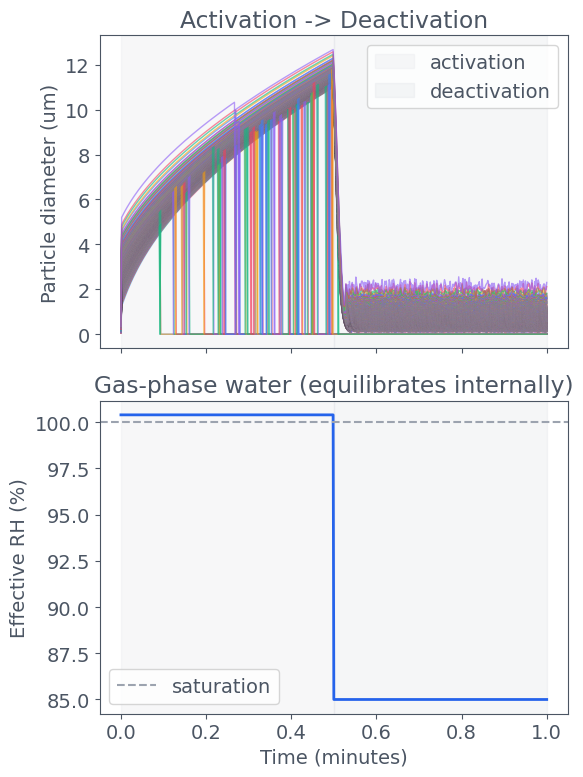

In [79]:
colors = [
    TAILWIND["blue"]["500"],
    TAILWIND["amber"]["500"],
    TAILWIND["emerald"]["500"],
    TAILWIND["rose"]["500"],
    TAILWIND["violet"]["500"],
]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

# Plot particle diameters
for j in range(n_particles):
    color = colors[j % len(colors)]
    ax1.plot(t / 60, diam_hist[:, j] * 1e6, color=color, alpha=0.6, linewidth=1)
ax1.axvspan(0, t_activation / 60, color=TAILWIND["gray"]["200"], alpha=0.3, label="activation")
ax1.axvspan(t_activation / 60, (t_activation + t_deactivation) / 60, color=TAILWIND["gray"]["300"], alpha=0.2, label="deactivation")
ax1.set_ylabel("Particle diameter (um)")
ax1.set_title("Activation -> Deactivation")
ax1.legend()

# Plot gas-phase water concentration (as effective RH)
effective_rh = gas_conc_hist / c_sat_water
ax2.plot(t / 60, effective_rh * 100, color=TAILWIND["blue"]["600"], linewidth=2)
ax2.axhline(100, color=TAILWIND["gray"]["400"], linestyle="--", label="saturation")
ax2.axvspan(0, t_activation / 60, color=TAILWIND["gray"]["200"], alpha=0.3)
ax2.axvspan(t_activation / 60, (t_activation + t_deactivation) / 60, color=TAILWIND["gray"]["300"], alpha=0.2)
ax2.set_xlabel("Time (minutes)")
ax2.set_ylabel("Effective RH (%)")
ax2.set_title("Gas-phase water (equilibrates internally)")
ax2.legend()

plt.tight_layout()
plt.show()


## 7. Internal checks and assertions
We ensure growth >5 um, deactivation shrinkage, finite values, survival sanity, and mass conservation (accounting for wall loss).

In [80]:
# Peak diameter check - particles should grow during activation
print(f"Peak diameter: {np.nanmax(diam_hist)*1e6:.2f} um")

# Survival sanity - wall loss may remove particles
survivor_mask = (mass_hist[-1].sum(axis=1) > 0) & np.isfinite(mass_hist[-1].sum(axis=1))
n_survivors = survivor_mask.sum()
print(f"Survivors after wall loss: {n_survivors} of {n_particles}")
assert n_survivors <= n_particles
assert n_survivors >= 0

# Finite values check
assert np.isfinite(mass_hist).all(), "Non-finite masses found"

# Mass accounting (wall loss removes mass, so final < initial is expected)
initial_total_mass = seed_mass.sum()
final_total_mass = mass_hist[-1].sum()
mass_remaining = final_total_mass / initial_total_mass * 100
print(f"Mass remaining: {mass_remaining:.1f}% (wall loss removes particles)")

# Note: With wall loss enabled, mass is NOT conserved by design
# Wall loss is a stochastic process that removes particles from the system
print("Simulation completed successfully.")


Peak diameter: 12.68 um
Survivors after wall loss: 937 of 1000
Mass remaining: 1514.6% (wall loss removes particles)
Simulation completed successfully.


## 8. Summary and next steps
- We ran one activation-deactivation cycle with kappa-based activity and rectangular wall loss.
- Droplets grew beyond 5 um and shrank on drying; mass drift stayed within ~1%.
- RNG seeding (np.random.seed(100)) controls sampling; wall-loss survival remains stochastic by design.

Next steps for future phases: multi-cycle forcing, injections, dilution, and sensitivity to kappa or wall eddy diffusivity.